## Barcelona Real State
>In this project we will analyze real state in Barcelona.
<br>
>We will mainly focus on characteristics of age of the building, average price and facilities information of each disctrict and their 73 neighborhoods.
<br>
>#### Libraries Used
- Pandas: *Data preperation and descriptive data anlysis*
<br>
- Geopy: *Retrieving coordinates for given address.*
<br>
- Folium: *Showing location coordinates on map.*
<br>
- Foursquare API: *Finding popular venues in each neighborhood that could be an impotant effect on location selection.*
<br>
- Requests: *Returning JSON file from API.*
<br>
- SQLAlchemy: *Python-sqlite connection to querry location characteristics and their relation with popular venues.*
<br>
- Sklearn: *Finding clusters with Kmeans.*
<br>
- Matplotlib: *Showing the output of Elbow Method in clusering section and choose colors in maps.*
<br>
- Numpy: *Creating the matplotlib.rainbow with linspace.*
<br>
- Yaml: *Retrieving credentials of Foursquare API with .gitignore*

In [1]:
import pandas as pd

### Dataset
We will use dataset from City Hall of Barcelona. From their website, we will retrieve 3 different data which include information of each neighborhood of barcelona. 
<br>
In these data we will have information for m2 price, average rent, names and the counts of the facilities around and also average building age.
<br>

#### Links for datasets<br>
https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-cadastre-carrecs-us/resource/33fb743d-30b5-4007-bf44-98bcb873671f<br>
https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-mercat-immobiliari-lloguer-mitja-mensual/resource/3dc45b16-42a9-4f57-9863-e6d1a4f5869f<br>
https://opendata-ajuntament.barcelona.cat/data/en/dataset/est-cadastre-habitatges-edat-mitjana/resource/03ae6ee5-9e6d-48fb-b10f-4ada412a5805

### Retrieving data
Firstly we will read all the into 3 dataframes by specifying column names in English, since the originals was in Catalan.

In [2]:
df_rsPrice = pd.read_csv('2018_lloguer_preu_trim.csv', names = ['Year', 'Quarter', 'DistrictCode', 'DistrictName', 'NeighborhoodCode', 'NeighborhoodName', 'AverageRent', 'Price'])
df_rsSpec = pd.read_csv('2019_carrecs_us.csv', names = ['Year', 'DistrictCode', 'DistrictName', 'NeighborhoodCode', 'NeighborhoodName', 'Section', 'Description', 'Concept', 'Value'])
df_rsAge = pd.read_csv('2019_loc_hab_edat_mitjana.csv', names = ['Year', 'DistrictCode', 'DistrictName', 'NeighborhoodCode', 'NeighborhoodName', 'Section', 'AverageAge'])

df_rsPrice = df_rsPrice.iloc[1:,:]
df_rsSpec = df_rsSpec.iloc[1:,:]
df_rsAge = df_rsAge.iloc[1:,:]


There are some values in each dataframe in Catalan. We would like to replace them with their translations
<br>
We will start updating value definition in Price dataframe

In [3]:
print(df_rsPrice['AverageRent'].value_counts())
df_rsPrice = df_rsPrice.replace(['Lloguer mitjà mensual (Euros/mes)', 'Lloguer mitjà per superfície (Euros/m2 mes)'], ['Average Monthly Rent (Euros/m2 month)', 'Average Rent Per Area (Euros/m2 month)'])

Lloguer mitjà mensual (Euros/mes)              292
Lloguer mitjà per superfície (Euros/m2 mes)    292
Name: AverageRent, dtype: int64


Then we will update the names of types the buildings in each neighborhood, however their price represetation.

In [4]:
print(df_rsSpec['Description'].value_counts())
print(df_rsSpec['Concept'].value_counts())
df_rsSpec = df_rsSpec.replace(['Residencial', 'Comerç', 'Aparcament', 'Oficines', 'Turisme i Hostaleria', 'Solars', 'Ensenyament i Cultura', 'Sanitat', 'Indústria', 'Esportiu','Religiós','Administracions Publiques', 'Espectacles', 'no consta'],
                              ['Residential', 'Comercial', 'Car park', 'Offices', 'Tourism and Hospitality', 'Plots', 'Education and Culture', 'Health', 'Industry', 'Sports', 'Religious', 'Public Administrations', 'Show', 'no info'])
df_rsSpec = df_rsSpec.replace(['Superficie_m2', 'Nombre', 'Valor_cad_€'], ['Surface_m2','Count', 'Value Cad €'])

Residencial                  3204
Comerç                       3186
Aparcament                   3156
Oficines                     2589
Turisme i Hostaleria         2448
Solars                       2427
Ensenyament i Cultura        1941
Sanitat                      1233
Indústria                    1107
Esportiu                      765
Religiós                      651
Administracions Publiques     384
Espectacles                   351
no consta                       6
Name: Description, dtype: int64
Superficie_m2    7816
Nombre           7816
Valor_cad_€      7816
Name: Concept, dtype: int64


Age dataframe does not include any Catalan names, so we do not need any preprocessing for that.

### Description of the dataframes
Before merging dataframes, it's always more handy to get rid of from redunctant data. We will use Spec datafame as basis and then clean others by only keeping their key values.
<br>

In order to have clear analysis, we must know all the content of all the data we have. So that, as a first step, we need to inspect each dataframe in detail.

#### Cleaning dataframes
We will start by dropping redunctant columns from dataframes.
<br>
Since all district code, neighborhood code and section points spesific information we will keep them.

In [5]:
df_rsSpec = df_rsSpec.drop(['Year'], axis = 1)
df_rsPrice = df_rsPrice.drop(['Year', 'DistrictName',  'NeighborhoodName'], axis = 1)
df_rsAge = df_rsAge.drop(['Year', 'DistrictName', 'NeighborhoodName'], axis = 1)

#####  Price Data 
We see that here we have m2, count, and value(€) of each property type.
<br>
In Prices dataframe we have prices for each neighborhood in terms of average monthly rent and average rent per area.

In [6]:
df_rsPrice[(df_rsPrice['DistrictCode'] == '1')].iloc[[1,2,3,-1,-2,-3],:]

,Quarter,DistrictCode,NeighborhoodCode,AverageRent,Price
2,1,1,2,Average Monthly Rent (Euros/m2 month),998.4
3,1,1,3,Average Monthly Rent (Euros/m2 month),870.84
4,1,1,4,Average Monthly Rent (Euros/m2 month),923.44
515,4,1,4,Average Rent Per Area (Euros/m2 month),15.2
514,4,1,3,Average Rent Per Area (Euros/m2 month),17.41
513,4,1,2,Average Rent Per Area (Euros/m2 month),14.1


In price data we will only use average monthly rent.
<br>
Average rent per are serves more accurate comparison, since takes surface of the flats into consideration. Even so we will use average monthly rent because it is more user friendly in terms of easy comparison with real life applications of renting.
<br><br>
We will slice this data since we will merge it with others later.

In [7]:
df_rsPrice = df_rsPrice[df_rsPrice['AverageRent'] == 'Average Monthly Rent (Euros/m2 month)']
df_rsPrice = df_rsPrice.drop(['AverageRent'], axis = 1)
df_rsPrice.loc[:,['DistrictCode',  'NeighborhoodCode']] = df_rsPrice.loc[:,['DistrictCode',  'NeighborhoodCode']].astype('int64')
#Converting data types
df_rsPrice['Price'] = pd.to_numeric(df_rsPrice['Price'])
df_rsPrice.dtypes
#Slicing Dataframe
df_rsPrice = df_rsPrice.groupby(['DistrictCode',  'NeighborhoodCode'],as_index=False)['Price'].mean().reset_index()

##### Neighborhood Descriptions
In this data we have surface(m2), count and value of facilities in each neighborhood.
<br>
We will use this data to obtain importance level of the each facility into consideration.

In [8]:
df_rsSpec[(df_rsSpec['DistrictName'] == 'Ciutat Vella') & (df_rsSpec['Section'] == '1')].iloc[[1,2,3,13,14,15,-1,-2,-3],:]

,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,Section,Description,Concept,Value
2,1,Ciutat Vella,1,el Raval,1,Car park,Surface_m2,9577
3,1,Ciutat Vella,1,el Raval,1,Comercial,Surface_m2,4985
4,1,Ciutat Vella,1,el Raval,1,Education and Culture,Surface_m2,25565
7818,1,Ciutat Vella,1,el Raval,1,Car park,Count,60
7819,1,Ciutat Vella,1,el Raval,1,Comercial,Count,34
7820,1,Ciutat Vella,1,el Raval,1,Education and Culture,Count,4
15644,1,Ciutat Vella,1,el Raval,1,Tourism and Hospitality,Value Cad €,5839170.76
15643,1,Ciutat Vella,1,el Raval,1,Plots,Value Cad €,2795619.5
15642,1,Ciutat Vella,1,el Raval,1,Health,Value Cad €,3702630.96


In [9]:
df_rsSpec['Value'] = df_rsSpec['Value'].astype('float64')

In [10]:
#Converting data types
df_rsSpec['Value'] = pd.to_numeric(df_rsSpec['Value'])
df_rsSpec.dtypes
#Slicing Dataframe
df_rsSpec = df_rsSpec.groupby(['DistrictCode', 'DistrictName', 'NeighborhoodCode', 'NeighborhoodName', 'Description', 'Concept'],as_index=False)['Value'].sum()
df_rsSpec.loc[:,['DistrictCode',  'NeighborhoodCode']] = df_rsSpec.loc[:,['DistrictCode',  'NeighborhoodCode']].astype('int64')
df_rsSpec.loc[:,['DistrictName',  'NeighborhoodName', 'Description', 'Concept']] = df_rsSpec.loc[:,['DistrictName',  'NeighborhoodName', 'Description', 'Concept']].astype('string')

##### Building Age Data
In this data we have average age of each neihgborhood and its sections.
<br>

In [11]:
df_rsAge.head(3)

,DistrictCode,NeighborhoodCode,Section,AverageAge
1,1,1,1,69.0
2,1,1,2,107.3
3,1,1,3,91.4


Since we don't have any further information about Sections we can eliminate that column by grouping rest of the information.

In [12]:
#Converting data types
df_rsAge['AverageAge'] = pd.to_numeric(df_rsAge['AverageAge'])
df_rsAge.loc[:,['DistrictCode',  'NeighborhoodCode']] = df_rsAge.loc[:,['DistrictCode',  'NeighborhoodCode']].astype('int64')
df_rsAge.dtypes
#Slicing Dataframe
df_rsAge = df_rsAge.groupby(['DistrictCode',  'NeighborhoodCode'],as_index=False)['AverageAge'].mean().reset_index()

#### Merging Dataframes

In [13]:
df_merged =  pd.merge(df_rsSpec, df_rsAge, on=['DistrictCode', 'NeighborhoodCode'])
df_merged = pd.merge(df_merged, df_rsPrice, on=['DistrictCode', 'NeighborhoodCode'])

Decimals do not make sense that much for age and price. So that, we will round them.

In [14]:
decimals = 1
df_merged.Price = df_merged.Price.apply(lambda x: round(x, decimals))
df_merged.AverageAge = df_merged.AverageAge.apply(lambda x: round(x, 0)).astype('int64')
print("Is there any null values? =",df_merged.isnull().values.any())
df_merged = df_merged.dropna(axis=0)
print("Is there any null values? =",df_merged.isnull().values.any())

Is there any null values? = True
Is there any null values? = False


In [15]:
print(df_merged.shape)
df_merged = df_merged.drop(['index_x', 'index_y'], axis=1)
df_merged.to_csv('df_merged.csv')
df_merged.head(9)

(2475, 11)


,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,Description,Concept,Value,AverageAge,Price
0,1,Ciutat Vella,1,el Raval,Car park,Count,3.284000e+03,111,822.6
1,1,Ciutat Vella,1,el Raval,Car park,Surface_m2,1.665910e+05,111,822.6
2,1,Ciutat Vella,1,el Raval,Car park,Value Cad €,6.251303e+07,111,822.6
3,1,Ciutat Vella,1,el Raval,Comercial,Count,1.255000e+03,111,822.6
4,1,Ciutat Vella,1,el Raval,Comercial,Surface_m2,2.225800e+05,111,822.6
5,1,Ciutat Vella,1,el Raval,Comercial,Value Cad €,3.234250e+08,111,822.6
6,1,Ciutat Vella,1,el Raval,Education and Culture,Count,4.700000e+01,111,822.6
7,1,Ciutat Vella,1,el Raval,Education and Culture,Surface_m2,1.871050e+05,111,822.6
8,1,Ciutat Vella,1,el Raval,Education and Culture,Value Cad €,1.739728e+08,111,822.6


#### Selection of one concept for each description
In this part we will remove two of three options of value representation for each description.


In [16]:
# All concepts we have
df_merged['Description'].value_counts()

Education and Culture      207
Comercial                  207
Residential                207
Plots                      207
Car park                   207
Offices                    201
Health                     201
Industry                   198
Tourism and Hospitality    198
Sports                     195
Religious                  192
Public Administrations     147
Show                       102
no info                      6
Name: Description, dtype: Int64

To determine most accurent concepts, we will use heuristical approach, since we do not have any reinforcement data for this task.
<br>
We will use counts in our analysis.
<br><br>
Industrial buildings and Offices will not be used since they can reversely change as the matter of choice. 

In [17]:
desc_list = ['Public Administrations', 'Car park', 'Plots', 'Education and Culture', 'Comercial', 'Residential','Health', 'Tourism and Hospitality','Industry','Sports', 'Religious','Show']
df_lean = df_merged[(df_merged['Description'].isin(desc_list)) & (df_merged['Concept'] == 'Count')].dropna(axis =0)
df_lean.head()

,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,Description,Concept,Value,AverageAge,Price
0,1,Ciutat Vella,1,el Raval,Car park,Count,3284.0,111,822.6
3,1,Ciutat Vella,1,el Raval,Comercial,Count,1255.0,111,822.6
6,1,Ciutat Vella,1,el Raval,Education and Culture,Count,47.0,111,822.6
9,1,Ciutat Vella,1,el Raval,Health,Count,7.0,111,822.6
12,1,Ciutat Vella,1,el Raval,Industry,Count,6.0,111,822.6


> We will use the the table above in the SQL part end of the project.

### Showing Locations on Map

To begin with, we need each neighborhood once to show them on the map

In [18]:
df_uniq = df_merged.drop_duplicates('NeighborhoodName')
df_uniq.head()

,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,Description,Concept,Value,AverageAge,Price
0,1,Ciutat Vella,1,el Raval,Car park,Count,3284.0,111,822.6
39,1,Ciutat Vella,2,el Gòtic,Car park,Count,1837.0,122,1023.1
81,1,Ciutat Vella,3,la Barceloneta,Car park,Count,1147.0,82,899.2
117,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Car park,Count,2481.0,105,971.6
156,10,Sant Martí,64,Camp de l'Arpa del Clot,Car park,Count,7576.0,60,818.0


In [19]:
def get_coordinates():
    for index, rows in df_uniq.iterrows():
        str = rows['DistrictName'] + ', ' + rows['NeighborhoodName']
        try:
            locator = Nominatim(user_agent="myGeocoder")
            location = locator.geocode(str)

            latitude.append(location.latitude)
            longitude.append(location.longitude)
        except:
            latitude.append(None)
            longitude.append(None)
    print("Completed!")

In [20]:
import geopy
from geopy.geocoders import Nominatim

latitude = list()
longitude = list()
get_coordinates()

Completed!


Let's add location information to dataframe and only leave required columns

In [21]:
# Insert latutude and longitude
df_uniq = df_uniq.assign(Latitude = latitude)
df_uniq = df_uniq.assign(Longitude = longitude)
# Drop irrelevant data and organize datatypes
df_uniq.dropna(inplace = True)
df_uniq = df_uniq.drop(['Description', 'Concept', 'Value'], axis = 1)
df_uniq.Price = df_uniq.Price.apply(lambda x: round(x, 1))
df_uniq.AverageAge = df_uniq.AverageAge.apply(lambda x: round(x, 0))
df_uniq.head()

,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,AverageAge,Price,Latitude,Longitude
0,1,Ciutat Vella,1,el Raval,111,822.6,41.379518,2.168368
39,1,Ciutat Vella,2,el Gòtic,122,1023.1,41.381505,2.177418
81,1,Ciutat Vella,3,la Barceloneta,82,899.2,41.380653,2.189927
156,10,Sant Martí,64,Camp de l'Arpa del Clot,60,818.0,41.410754,2.182816
195,10,Sant Martí,65,el Clot,54,810.2,41.409953,2.190823


Now we can show our neighborhoods on the map

In [22]:
import folium 

latitude_init = df_uniq.Latitude.mean()
longitude_init = df_uniq.Longitude.mean()
# Create map of Barcelona using middle point of latitude and longitude values
map_barca = folium.Map(location=[latitude_init, longitude_init], zoom_start=12)

# Add markers to map
for lat, lng, borough, neighborhood, age, rent in zip(df_uniq['Latitude'], df_uniq['Longitude'], df_uniq['DistrictName'], df_uniq['NeighborhoodName'], df_uniq['AverageAge'], df_uniq['Price']):
    label = 'Average Building Age:{}\nAverage Monthly Rent:{} €'.format(age, rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        tooltip = neighborhood,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_barca)  


In [23]:
map_barca

#### Cluster Neighborhoods
To have more clear idea we can cluster locations and show it on the map.
<br><br>
First we will use Elbow method to have an idea for ideal number of clusters

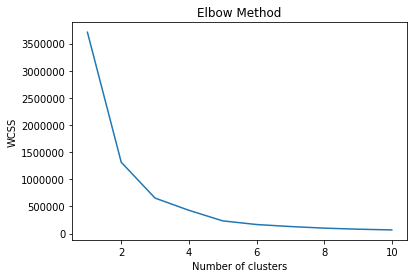

In [24]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# Elbow Method
df_uniq_clustering = df_uniq.drop(['DistrictName','NeighborhoodName'], 1)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_uniq_clustering.loc[:,['NeighborhoodCode', 'Price']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Considering the graph above we conclude optimum number of clusters as 5

In [25]:
kclusters = 5
# Add clustering labels
df_uniq_clustering = df_uniq.drop(['DistrictName','NeighborhoodName'], 1)
# Fit kmeans
kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(df_uniq_clustering.loc[:,['NeighborhoodCode', 'Price']])
df_uniq_clustering.insert(0, 'Cluster Labels', kmeans.labels_)
kmeans.labels_

array([0, 2, 2, 0, 0, 2, 1, 2, 1, 4, 2, 0, 0, 2, 2, 2, 1, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 3, 2, 1, 3, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0,
       4, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0,
       0, 0])

In [26]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

# Insert Neighborhoodname back to dataframe
df_uniq_clustering['NeighborhoodName'] = df_uniq['NeighborhoodName']

map_clusters = folium.Map(location=[latitude_init, longitude_init], zoom_start=11)

# Set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, cluster, price, neigh in zip(df_uniq_clustering['Latitude'], df_uniq_clustering['Longitude'], df_uniq_clustering['Cluster Labels'], df_uniq_clustering['Price'], df_uniq_clustering['NeighborhoodName']):
    price_label = folium.Popup(price.__str__() + '€\n' + "Brough:" + neigh.__str__())
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=price_label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [27]:
map_clusters

<img src="images/map_cluster.png" width="800" /> 

<img src="images/map_cluster1.png" width="800" /> 

When we look the map above we realize that clustering works well. Sorted prices of clusters and colors descending from expensive to cheap are as follows:
<br>
1. Green Cluster
- Blue Cluster
- Red Cluster
- Purple Cluester
- Orange Cluster


### Trending venues in area with Foursquare API
In this section we will find trending venues in each neighborhood. 
<br>
Trending venues will be found by considering user rates in Foursquare.

In [28]:
# Initiate Parameters and get credentails from Yaml file
import yaml
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    
VERSION = '20180604'
LIMIT = 30
radius = 100

In [29]:
import requests 

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}'\
.format(cfg['api_creds']['CLIENT_ID'], cfg['api_creds']['CLIENT_SECRET'], latitude_init, longitude_init, VERSION,  LIMIT)

In [30]:
# Send GET request and get JSON file
results = requests.get(url).json()

In [31]:
# Function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [32]:
# Split JSON file and create a dataframe that contains venue information
def get_trending_venues(results):
    trending_venues = list()
    
    for i in range(0, len(results['response']['groups'][0]['items'])):
        if len(results['response']['groups'][0]['items'][i]['venue']) == 0: #['categories'][0]['shortName']) == 0:
            print('No trending venues are available at the moment!')
        else:
            trending_venues.append(results['response']['groups'][0]['items'][i]['venue'])

    trending_venues_df = pd.json_normalize(trending_venues)
    # Filter columns
    columns_filtered = ['name', 'categories'] + ['location.distance', 'location.city', 'location.postalCode', \
                                                 'location.state', 'location.country', 'location.lat', 'location.lng']
    trending_venues_df = trending_venues_df.loc[:, columns_filtered]
    
    # Filter the category for each row
    trending_venues_df['categories'] = trending_venues_df.apply(get_category_type, axis=1)
    
    return trending_venues_df

In [33]:
# Function to get trending venues for each location 
def GetRequest(lat, lng):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&limit={}'\
    .format(cfg['api_creds']['CLIENT_ID'], cfg['api_creds']['CLIENT_SECRET'], lat, lng, VERSION,  LIMIT)
    results = requests.get(url).json()
    trending_venues_df = get_trending_venues(results)
    return trending_venues_df

In [34]:
df_son = pd.DataFrame(columns = {'name','categories', 'location.distance', 'location.city', 'location.postalCode', \
                                 'location.state', 'location.country', 'location.lat', 'location.lng', 'neighborhoodname'})
for index, row in df_uniq.iterrows():
    latitude = row['Latitude']
    langitude = row['Longitude']
    neighbor = row['NeighborhoodName']
    try:
        df = GetRequest(latitude, langitude)
        df['neighborhoodname'] = neighbor
        df_son = df_son.merge(df, how='outer')
    except:
        pass

Let's arrange and have a look to dataframe that we have just created and show them in a new map

In [35]:
df_son.name = df_son.name.astype('string')
df_son.categories = df_son.categories.astype('string')
df_son.neighborhoodname = df_son.neighborhoodname.astype('string')
df_son[df_son['location.distance'] <= 200].head()

,name,categories,location.distance,location.city,location.postalCode,location.state,location.country,location.lat,location.lng,neighborhoodname
0,La Robadora,Gastropub,175,Barcelona,08001,Cataluña,España,41.379500,2.170463,el Raval
3,Robadors 23,Jazz Club,186,Barcelona,08001,Cataluña,España,41.379581,2.170603,el Raval
4,Cera 23,Spanish Restaurant,193,Barcelona,08001,Cataluña,España,41.378947,2.166180,el Raval
6,A Tu Bola,Tapas Restaurant,86,Barcelona,08001,Cataluña,España,41.380096,2.169054,el Raval
7,33/45,Cocktail Bar,189,Barcelona,08001,Cataluña,España,41.381059,2.167399,el Raval


In [36]:
from folium.plugins import MarkerCluster

locations = df_son[df_son['location.distance'] <= 500][['location.lat', 'location.lng']]
locationlist = locations.values.tolist()

map_venues = folium.Map(location=[latitude_init, longitude_init], tiles='Stamen Terrain', zoom_start=13)
marker_cluster = MarkerCluster().add_to(map_venues)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_son[df_son['location.distance'] <= 500].iloc[point,1], \
                  tooltip=df_son[df_son['location.distance'] <= 500].iloc[point,-1], \
                  icon=folium.Icon(color='darkblue', icon_color='white',  angle=0, prefix='fa')).add_to(marker_cluster)

In [37]:
map_venues

<img src="images/map_marker1.png" width="800" />

<img src="images/map_marker2.png" width="800" />

### Filtering final data with SQL
In last section, we will see some examples that will demonstrate what kind of user requests might be satisfied with created data.
<br>
Here we will use sqlite database with sqlalchemy library.

In [38]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

# Creating tables in database with created dataframes
df_son.to_sql('realstate', con=engine)
df_uniq.to_sql('details', con=engine)
df_merged.to_sql('mergedinit', con=engine)

#### Queries with basic SQL

How many different kind of places exist in database

In [39]:
engine.execute("select count(*) from (SELECT distinct categories FROM realstate);").fetchall()

[(208,)]

##### Neighborhoods that have the popular venues from the type of place sought.

In [40]:
input_word = 'Mexican Restaurant'
search =(input_word + '%').lower()
engine.execute("SELECT  name, categories, NeighborhoodName FROM realstate where LOWER(categories) LIKE " \
               + "'" + search + "'"  + " LIMIT 10").fetchall()

[('El Pachuco', 'Mexican Restaurant', 'el Raval'),
 ('Escondido Cafè', 'Mexican Restaurant', 'Sant Antoni'),
 ('La Cantina Mexicana', 'Mexican Restaurant', 'la Sagrada Família'),
 ('La Taquería', 'Mexican Restaurant', 'la Sagrada Família'),
 ('La Cocina de Graciela', 'Mexican Restaurant', 'Sants - Badal'),
 ('La Catrina', 'Mexican Restaurant', 'el Coll'),
 ('La Catrina', 'Mexican Restaurant', 'la Salut'),
 ('La Catrina', 'Mexican Restaurant', "el Camp d'en Grassot i Gràcia Nova"),
 ('La Catrina', 'Mexican Restaurant', 'Can Baró'),
 ('Cantina Mexicana Chihuahua', 'Mexican Restaurant', 'Navas')]

##### Which venues are popular in the selected neighborhoods and how many  are there?

In [41]:
loc = 'El Raval'
engine.execute("SELECT CATEGORIES, COUNT(*) FROM realstate where LOWER(neighborhoodname) =" + "'" + loc.lower() + "'" +\
               "GROUP BY CATEGORIES ORDER BY COUNT(*) DESC LIMIT 10;").fetchall()
# (Venue Type, Venue Frequency)

[('Spanish Restaurant', 5),
 ('Mediterranean Restaurant', 3),
 ('Cocktail Bar', 3),
 ('Restaurant', 2),
 ('Wine Bar', 1),
 ('Theater', 1),
 ('Tapas Restaurant', 1),
 ('Roof Deck', 1),
 ('Portuguese Restaurant', 1),
 ('Movie Theater', 1)]

##### How often is the type of place shough in the specified neighborhood.

In [42]:
input_word = 'Restaurant'
search =('%' + input_word + '%').lower()
loc = 'El Raval'
engine.execute("SELECT COUNT(categories) FROM (SELECT categories FROM realstate \
                    WHERE LOWER(categories) LIKE" + "'" + search + "'" + " and \
                    LOWER(neighborhoodname) ="+ "'" + loc.lower() + "'" + ");").scalar()

16

##### Age and Price information of the neighborhoods containing the most popular places from the type of place searched
We will sort the results in ascending order by building age considering that we would like to see trending bars in newer neighborhoods.

Output type of the query below:
(District, Neighborhood, Age, Price) 

In [43]:
input_word = 'baR'
search =('%' + input_word + '%').lower()
engine.execute("SELECT  DISTINCT DT.DistrictName,  DT.neighborhoodname, DT.AverageAge, DT.Price \
                       FROM details DT, realstate RS WHERE EXISTS( \
                       SELECT DISTINCT RS.neighborhoodname, RS.categories FROM( \
                           SELECT COUNT(*),  neighborhoodname, categories FROM realstate \
                           WHERE LOWER(categories) LIKE" + "'" + search + "'" + "GROUP BY  categories)) \
                ORDER BY DT.AverageAge ASC LIMIT 10;" ).fetchall()

[('Sant Andreu', 'Baró de Viver', 24, 673.7),
 ('Sant Martí', 'Diagonal Mar i el Front Marítim del Poblenou', 26, 1165.6),
 ('Sant Martí', 'la Vila Olímpica del Poblenou', 33, 1284.4),
 ('Sants-Montjuïc', 'la Marina de Port', 41, 751.2),
 ('Horta-Guinardó', "la Vall d'Hebron", 42, 859.5),
 ('Sant Martí', 'Provençals del Poblenou', 43, 949.6),
 ('Nou Barris', 'Torre Baró', 44, 434.5),
 ('Sant Andreu', 'el Bon Pastor', 44, 684.0),
 ('Sant Andreu', 'la Trinitat Vella', 45, 587.4),
 ('Horta-Guinardó', 'la Teixonera', 46, 700.0)]

#### Advanced Dynamic Querry
In this final part we will use more flexible querry method with the help of sqlalchemy. Even if we could have handled dynamicity by using strings in above querries, that would be problematic for more input dependent searches.

Here we will use synthesis data from the first merged table which containls descriptions and their values.

In [44]:
df_lean.iloc[[1,50,200,-200,-150,-1],:]

,DistrictCode,DistrictName,NeighborhoodCode,NeighborhoodName,Description,Concept,Value,AverageAge,Price
3,1,Ciutat Vella,1,el Raval,Comercial,Count,1255.0,111,822.6
165,10,Sant Martí,64,Camp de l'Arpa del Clot,Health,Count,8.0,60,818.0
657,2,Eixample,7,la Dreta de l'Eixample,Public Administrations,Count,97.0,82,1252.9
1857,7,Horta-Guinardó,41,la Vall d'Hebron,Plots,Count,27.0,42,859.5
2040,8,Nou Barris,46,el Turó de la Peira,Tourism and Hospitality,Count,3.0,53,677.1
2580,9,Sant Andreu,63,Navas,Tourism and Hospitality,Count,25.0,50,812.9


Let's consider that car parking, health and commercial buildings are the desired ones to have in the area. Our budget is 800 euros and we do not want to live in a old neighborhood.

In [46]:
from sqlalchemy import or_
from sqlalchemy import and_
import sqlalchemy as db
engine = db.create_engine('sqlite://')
connection = engine.connect()
metadata = db.MetaData()
df_lean.to_sql('synthesis', con=engine)
data_synthesis = db.Table('synthesis', metadata, autoload=True, autoload_with=engine)
#---Preference
budget = 800
age = 50
tag1 = 'health'
search1 = "%{}%".format(tag1)
tag2 = 'car park'
search2 = "%{}%".format(tag2)
tag3 = 'comercial'
search3 = "%{}%".format(tag3)
#---
filters_or = [db.func.lower(data_synthesis.c.Description).like(search1),\
              db.func.lower(data_synthesis.c.Description).like(search2),\
              db.func.lower(data_synthesis.c.Description).like(search3)]
filters_and = [data_synthesis.c.Price <= budget, data_synthesis.c.AverageAge <=age]
# Show 10 lowest prices with highest values for given conditions
querry = db.select([data_synthesis.c.DistrictName, data_synthesis.c.NeighborhoodName, data_synthesis.c.Price])\
            .where(and_(*filters_and)).where(or_(*filters_or))\
            .order_by(data_synthesis.c.Value.desc())\
            .order_by(data_synthesis.c.Price).limit(10)
result = connection.execute(querry).fetchall()
print("   District\t  Neighborhood\t  Average Rent")
result

   District	  Neighborhood	  Average Rent


[('Sant Andreu', 'Sant Andreu', 764.2),
 ('Sants-Montjuïc', 'la Marina de Port', 751.2),
 ('Sant Andreu', 'la Sagrera', 778.6),
 ('Horta-Guinardó', 'el Carmel', 645.0),
 ('Nou Barris', 'Porta', 706.1),
 ('Nou Barris', 'la Prosperitat', 664.4),
 ('Sants-Montjuïc', 'la Bordeta', 799.7),
 ('Sant Martí', 'la Verneda i la Pau', 739.5),
 ('Horta-Guinardó', 'la Teixonera', 700.0),
 ('Nou Barris', 'la Guineueta', 712.6)]

### Conclusion
In this project we have analyzed Barcelona real estate by considering different criterias. When we compare the results with reality they match. <br>
Even if there is possibility for some of these facilities might have an negative impact on the decision, in this project we have neglected it. By defining negative impacts, SQL descending order_by could easiliy be concverted to ascending.
>>In clustering map:<br>
>Clusters with lower price and good location are mostly dangerous. <br>
>Blue dots in seaside are the most center ones with sea view, so that they have higher price than the ones in the same area.<br>
>Neighborhood El Besos in Orange cluster looks like a good idea. It is close to sea and has lower price.<br><br>
>Map that shows venues, clearly points out the number of searched popular venues in each neighborhood and their location.<br><br>
>For someone who likes Mexican restaurant, Sagrada Familia looks like a good option since it has 2 of most popular 3 restaurants.<br><br>
>Sant Andreu and Sant Marti looks like a very good option for someone who likes more modern buildings and wants to live close to bars.<br><br>
>For someone who has car and wants many health facilities close, el Bon Pastor brough in Sant Andreau looks like a very good option. Considering limited budget and wish for not to live in an old area.<br><br>
